In [50]:
import numpy as np
import pandas as pd
import dabest
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
my_color_palette =  {'Dz 5mg/kg':'#8FB996','NaCl':'#594157', 'PTZ 20mg/kg':'#c7991a'}

In [51]:
# Load data LFP data of one example animal
animal = 'Ent_CamK2_42'
All_LFP_df = pd.read_pickle('Mice_data/'+animal+'_all_LFP_df')
channels = ["ENT R ventral", "ENT R dorsal", "CA1 R", "CA3 R", "DG R","Sub R", "CA3 L","CA1 L", "DG L",
                     "Sub L", "ENT L dorsal", "ENT L ventral"]

In [52]:
# Function which calculate Pearson correlation across channels in a paire-wise manner 
def Pearson_correlation_matrix_with_nan(data):
    nb_channel = len(data)
    corr_matrix = np.zeros((nb_channel,nb_channel))
    p_val_matrix = np.zeros((nb_channel,nb_channel))
    for idx_1 in range(nb_channel):
        row_1 = data[idx_1]
        for idx_2 in range(nb_channel):
            row_2 = data[idx_2]
            if np.nansum(row_1) == 0 or np.nansum(row_2) == 0:
                corr, p_value = np.nan, np.nan
            else:
                corr, p_value = stats.pearsonr(row_1,row_2)
            corr_matrix[idx_1,idx_2] = np.abs(corr)
            p_val_matrix[idx_1,idx_2] = p_value

    return corr_matrix, p_val_matrix

In [65]:
# For each LFP bout, compute the correlation matrix across channels and extracte the mean spatial correlation 
for i_r,row in All_LFP_df.iterrows():
    data_LFP = np.array(row[channels].tolist())
    corr_matrix, p_val_matrix = Pearson_correlation_matrix_with_nan(np.abs(data_LFP))
    corr_matrix[np.diag_indices(len(corr_matrix))] = np.nan  # Nan diagonal
    mean_corr_per_channel = np.nanmean(corr_matrix)
    
    All_LFP_df.at[i_r,'Correlation matrix'] = corr_matrix
    All_LFP_df.at[i_r,'Mean Spatial Correlation'] = mean_corr_per_channel

In [66]:
# Normalize correlation values to the control ('NaCl') condition
def Nomralization_xcorr_matrice_by_block(df, metric):
    all_block = np.sort(np.unique(df["Block"]))
    df['Normalized ' + metric] = np.nan
    for block in all_block:
        List_matrix_NaCl = np.array(df[metric] [(df['Artefact'] ==  False) & (df['Condition'] == 'NaCl')& (df['Block'] == block)].tolist())
        mean_NaCl_matrix = np.nanmean(List_matrix_NaCl,axis=0)
        df.loc[df['Block'] == block,'Normalized ' + metric] = df[metric][df['Block'] == block].apply(lambda x: x / mean_NaCl_matrix)

    return (df)

All_LFP_df = Nomralization_xcorr_matrice_by_block(All_LFP_df,'Correlation matrix')

/var/folders/6r/0p67bvdn7t75cb5rwnqb9qdr0000gn/T/ipykernel_5021/343651480.py:7: RuntimeWarning: Mean of empty slice
  mean_NaCl_matrix = np.nanmean(List_matrix_NaCl,axis=0)


/var/folders/6r/0p67bvdn7t75cb5rwnqb9qdr0000gn/T/ipykernel_5021/1299812875.py:7: RuntimeWarning: Mean of empty slice
  Mean_corr_matrix_cat = np.nanmean(list_matric_cnd, axis=0)


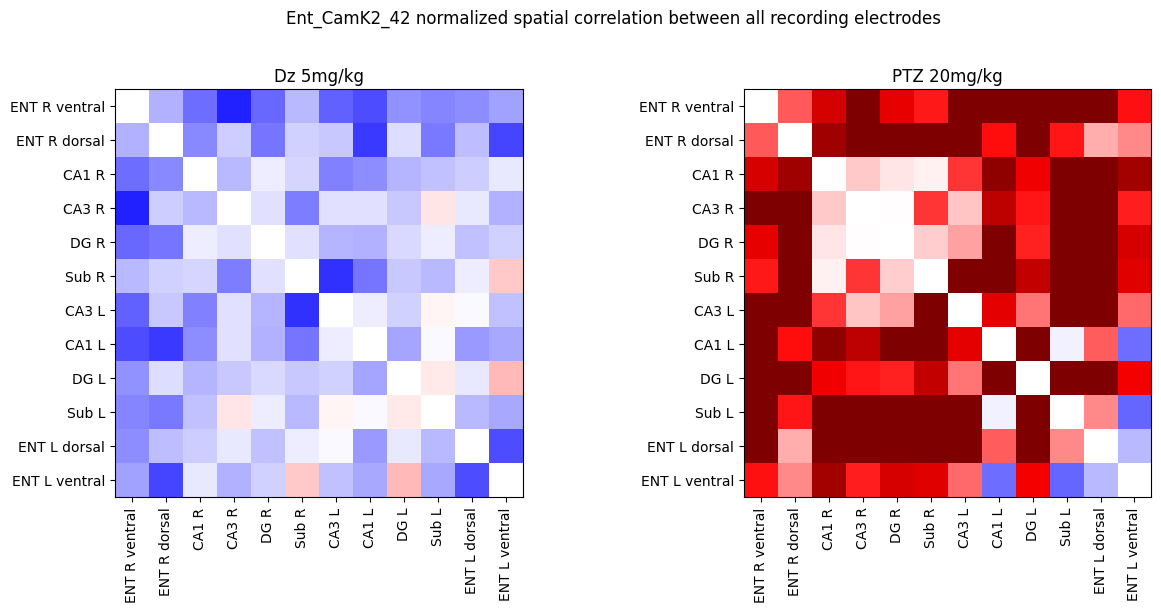

In [67]:
condition_to_plot = ['Dz 5mg/kg',  'PTZ 20mg/kg']
title_1 = animal + ' normalized spatial correlation between all recording electrodes'
fig = plt.figure(title_1, figsize=(16, 8)).suptitle(title_1)
divnorm_diff = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)
for i_cnd, cnd in enumerate(condition_to_plot):
    list_matric_cnd = np.array(All_LFP_df['Normalized Correlation matrix'] [(All_LFP_df['Condition'] == cnd)].tolist())
    Mean_corr_matrix_cat = np.nanmean(list_matric_cnd, axis=0)
    ax = plt.subplot2grid((12, 12), (0, int(i_cnd * (12 / len(condition_to_plot)))), rowspan=8, colspan=int(12 / len(condition_to_plot)))
    ax.set_title(cnd)
    im = ax.imshow(Mean_corr_matrix_cat, cmap='seismic', norm=divnorm_diff)
    ax.set_xticks(np.arange(0, len(channels)))
    ax.set_xticklabels(ax.get_xticks(), rotation=90)
    ax.set_xticklabels(channels)
    ax.set_yticks(np.arange(0, len(channels)))
    ax.set_yticklabels(channels)

In [63]:
# Load Mean Spatial Correlation across animals and sessions
Spatial_corr_df = pd.read_pickle('Mice_data/'+'Spatial_Corr_df')
cnd_order = ['NaCl','PTZ 20mg/kg','Dz 5mg/kg']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dabest/plotter.py:389: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  rawdata_plot = sns.swarmplot(data=plot_data, x=xvar, y=yvar,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dabest/plotter.py:438: UserWarning: FixedFormatter should only be used together with FixedLocator
  rawdata_axes.set_xticklabels(ticks_with_counts)


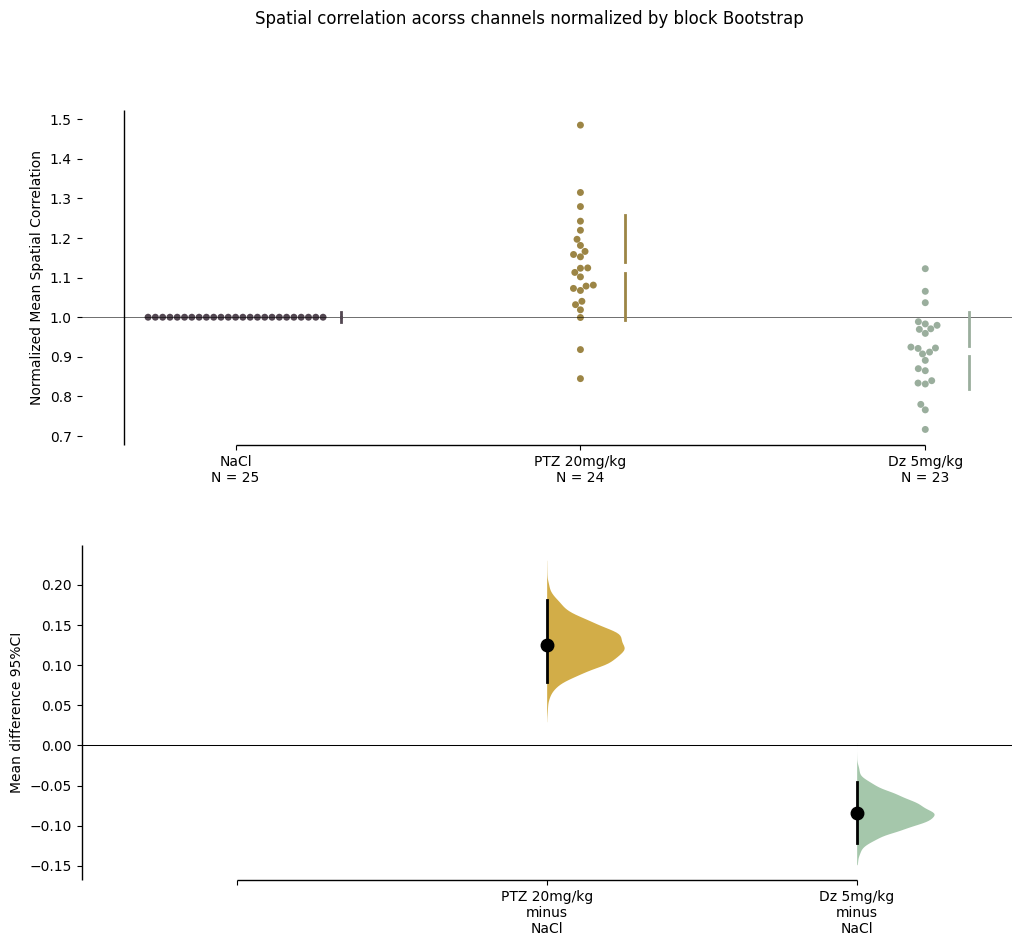

In [64]:
title = 'Spatial correlation acorss channels normalized by block Bootstrap '
fig2 = plt.figure(title, figsize=(12, 10)).suptitle(title)
ax1 = plt.subplot2grid((12, 12), (0, 0), rowspan=12, colspan=12)
ax1.axhline(y=1, color='k',  linewidth=0.5, alpha=0.8)
multi_groupe = dabest.load(Spatial_corr_df, idx= cnd_order, x="Condition", y= 'Normalized Mean Spatial Correlation')
multi_groupe.mean_diff.plot(ax=ax1,raw_marker_size=5,contrast_label="Mean difference 95%CI",custom_palette=my_color_palette)
result_Bootstrap = multi_groupe.mean_diff.statistical_tests